# Project - Realtime Object Detection

## Importing Libraries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

2025-06-18 11:33:18.577797: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-18 11:33:18.628563: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-18 11:33:18.660046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750260798.687457   95177 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750260798.694656   95177 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750260798.723951   95177 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## Importing data

In [2]:
#Defining labels per dataset

# VisDrone categories of interest (ignore 0=ignored regions, 11=others)
visdrone_labels = {
    1: "pedestrian",
    2: "people",
    3: "bicycle",
    4: "car",
    5: "van",
    6: "truck",
    7: "tricycle",
    8: "awning-tricycle",
    9: "bus",
    10: "motor"
}

mot17_labels = {1: "pedestrian"}  # single-class

In [3]:
# --- Root directory for datasets ---
data_root = "../data"

# --- Training sequence definitions ---
train_folders = [
    {
        "dataset": "MOT17",
        "img_path": os.path.join(data_root, "MOT17/train/MOT17-04/img1"),
        "ann_path": os.path.join(data_root,"MOT17/train/MOT17-04/gt/gt.txt"),
        "type": "mot"
    },
    {
        "dataset": "VisDrone",
        "img_path": os.path.join(data_root, "VisDrone2019/train/sequences/uav0000366_00001_v"),
        "ann_path": os.path.join(data_root, "VisDrone2019/train/annotations/uav0000366_00001_v.txt"),
        "type": "visdrone"
    },
    {
        "dataset": "VisDrone",
        "img_path": os.path.join(data_root, "VisDrone2019/train/sequences/uav0000013_01073_v"),
        "ann_path": os.path.join(data_root, "VisDrone2019/train/annotations/uav0000013_01073_v.txt"),
        "type": "visdrone"
    }

    # Add more VisDrone sequences as needed
]


In [4]:
#Creating a unified load sequence with correct annotation parsing
def load_sequence(info):
    if info["type"] == "mot":
        img_dir = info["img_path"]
        gt_path = info["ann_path"]
        labels = mot17_labels
    elif info["type"] == "visdrone":
        img_dir = info["img_path"]
        gt_path = info["ann_path"]
        labels = visdrone_labels
    else:
        raise ValueError("Unsupported dataset type.")

    image_files = sorted([
        os.path.join(img_dir, f) for f in os.listdir(img_dir)
        if f.endswith('.jpg')
    ])

    annotations = {}

    with open(gt_path, 'r') as f:
        for line in f:
            fields = line.strip().split(',')
            if info["type"] == "mot":
                if len(fields) < 8:
                    continue
                try:
                    frame_id = int(fields[0])
                    x, y, w, h = map(float, fields[2:6])
                    mark = int(fields[6])
                    obj_class = int(float(fields[7]))
                except:
                    continue

                if mark != 1 or obj_class not in labels:
                    continue

            elif info["type"] == "visdrone":
                if len(fields) < 10:
                    continue
                try:
                    frame_id = int(fields[0])
                    x, y, w, h = map(float, fields[2:6])
                    score = int(float(fields[6]))
                    obj_class = int(float(fields[7]))
                except:
                    continue

                if obj_class not in labels or score != 1:
                    continue

            box = [x, y, x + w, y + h, obj_class]
            annotations.setdefault(frame_id, []).append(box)

    return image_files, annotations, labels

In [5]:
def show_frame_with_boxes(img_path, boxes, class_labels):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for box in boxes:
        x1, y1, x2, y2, cls = map(int, box)
        label = class_labels.get(cls, str(cls))
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)

    plt.imshow(img)
    plt.axis('off')
    plt.show()


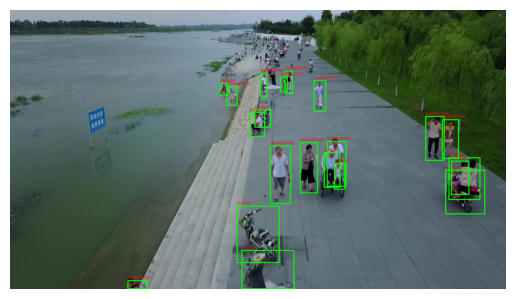

In [6]:
# Load a sequence (0 = MOT17, 1 = VisDrone)
sequence_info = train_folders[2]
img_files, annotations, labels = load_sequence(sequence_info)

# Show a frame
frame_id = 10
show_frame_with_boxes(img_files[frame_id], annotations.get(frame_id + 1, []), labels)


### Using Tensorflow for preprocessing the data

In [7]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 8
GRID_SIZE = 14  # from model
MAX_BOXES = GRID_SIZE * GRID_SIZE  # 196

# --- Step 1: Define preprocessing function ---
def preprocess_image_and_boxes(img_path, boxes):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    orig_shape = tf.shape(img)[:2]

    # Resize and normalize
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0

    # Convert to tensor
    boxes = tf.convert_to_tensor(boxes, dtype=tf.float32)

    # Rescale boxes
    scale_y = tf.cast(IMG_SIZE[0], tf.float32) / tf.cast(orig_shape[0], tf.float32)
    scale_x = tf.cast(IMG_SIZE[1], tf.float32) / tf.cast(orig_shape[1], tf.float32)
    
    boxes_scaled = tf.stack([
        boxes[:, 0] * scale_x,
        boxes[:, 1] * scale_y,
        boxes[:, 2] * scale_x,
        boxes[:, 3] * scale_y,
        boxes[:, 4]  # class ID
    ], axis=1)

    return img, boxes_scaled

In [8]:
# --- Step 2: Prepare image paths and boxes ---
all_img_paths = []
all_boxes = []
all_classes = set()

# train_folders is assumed to be defined already
for seq_info in train_folders:
    img_files, annotations, labels = load_sequence(seq_info)

    for frame_id, frame_path in enumerate(img_files):
        frame_key = frame_id + 1
        boxes = annotations.get(frame_key, [])
        if boxes:
            all_img_paths.append(frame_path)
            all_boxes.append(boxes)
            for box in boxes:
                all_classes.add(int(box[4]))

In [9]:
# --- Step 3: Normalize class IDs to 0-based continuous IDs ---
original_ids = sorted(list(all_classes))
class_id_map = {orig_id: new_id for new_id, orig_id in enumerate(original_ids)}
NUM_CLASSES = len(class_id_map)

# --- Step 4: Dataset generator ---
def generator():
    for img_path, box_list in zip(all_img_paths, all_boxes):
        new_box_list = []
        for box in box_list[:MAX_BOXES]:  # clip to MAX_BOXES
            new_box = box[:4] + [class_id_map[int(box[4])]]
            new_box_list.append(new_box)
        yield img_path, new_box_list

dataset = tf.data.Dataset.from_generator(
    generator,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(None, 5), dtype=tf.float32)
    )
)

# --- Step 5: Apply preprocessing ---
dataset = dataset.map(preprocess_image_and_boxes, num_parallel_calls=tf.data.AUTOTUNE)

# --- Step 6: Pad, batch, prefetch ---
dataset = dataset.shuffle(512).padded_batch(
    BATCH_SIZE,
    padded_shapes=([IMG_SIZE[0], IMG_SIZE[1], 3], [MAX_BOXES, 5]),
    padding_values=(0.0, 0.0)
).prefetch(tf.data.AUTOTUNE)

def format_for_model(img, boxes_with_labels):
    bboxes = boxes_with_labels[:, :, :4]  # (batch, 196, 4)
    class_ids = boxes_with_labels[:, :, 4]  # (batch, 196)
    objectness = tf.cast(tf.not_equal(class_ids, 0), tf.float32)  # 1 if valid box, else 0
    return img, {
        "bbox": bboxes,
        "objectness": objectness,
        "class_logits": class_ids
    }

train_dataset = dataset.map(format_for_model)

E0000 00:00:1750260802.370260   95177 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1750260802.371121   95177 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
# Optional: print sample batch
for images, labels in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("bbox shape:", labels["bbox"].shape)
    print("objectness shape:", labels["objectness"].shape)
    print("class_logits shape:", labels["class_logits"].shape)

Image batch shape: (8, 224, 224, 3)
bbox shape: (8, 196, 4)
objectness shape: (8, 196)
class_logits shape: (8, 196)


2025-06-18 11:33:23.579577: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Building a custom CNN model

In [11]:
from keras.saving import register_keras_serializable

@register_keras_serializable()
def split_bbox(t):
    return t[:, :, :4]

@register_keras_serializable()
def split_objectness(t):
    return tf.sigmoid(t[:, :, 4])

@register_keras_serializable()
def split_class_logits(t):
    return t[:, :, 5:]

def custom_detector_grid(input_shape=(224, 224, 3), num_classes=11):
    inputs = layers.Input(shape=input_shape)

    # --- Backbone ---
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D()(x)   # 112x112
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)   # 56x56
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)   # 28x28
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)   # 14x14 (spatial grid)

    # --- Detection Head ---
    # Each grid cell predicts 4 bbox coords + 1 objectness + num_classes class scores
    output_channels = 4 + 1 + num_classes  # 4 = bbox, 1 = objectness, N = class logits
    x = layers.Conv2D(output_channels, 1, padding="same")(x)  # output shape: (14, 14, C)

    # --- Reshape output ---
    x = layers.Reshape((14 * 14, output_channels))(x)  # (196, 4+1+N)

    bbox_out = layers.Lambda(split_bbox, name="bbox")(x)
    objectness_out = layers.Lambda(split_objectness, name="objectness")(x)
    class_out = layers.Lambda(split_class_logits, name="class_logits")(x)

    return models.Model(inputs=inputs, outputs=[bbox_out, objectness_out, class_out])


In [12]:
# #Loss Setup
# losses = {
#     "bbox": tf.keras.losses.MeanSquaredError(),
#     "class_logits": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# }


In [13]:
model = custom_detector_grid(
    input_shape=(224, 224, 3),
    num_classes=NUM_CLASSES
)

model.compile(
    optimizer="adam",
    loss={
        "bbox": tf.keras.losses.Huber(),
        "objectness": tf.keras.losses.BinaryCrossentropy(from_logits=False),
        "class_logits": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    }
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 14, 14,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 14, 14,    │      3,084 │ max_pooling2d_3[… │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 196, 12)   │          0 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox (Lambda)       │ (None, 196, 4)    │          0 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ objectness (Lambda) │ (None, 196)       │          0 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_logits        │ (None, 196, 7)    │          0 │ reshape[0][0]     │
│ (Lambda)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 391,500 (1.49 MB)

 Trainable params: 391,500 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.fit(train_dataset.repeat(), epochs=10, steps_per_epoch=176)

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 66s 358ms/step - bbox_loss: 17.5778 - class_logits_loss: 0.3250 - loss: 18.0945 - objectness_loss: 0.1916
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 60s 339ms/step - bbox_loss: 15.2501 - class_logits_loss: 0.1019 - loss: 15.4393 - objectness_loss: 0.0871
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 56s 314ms/step - bbox_loss: 14.9968 - class_logits_loss: 0.0965 - loss: 15.1778 - objectness_loss: 0.0844
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 58s 327ms/step - bbox_loss: 14.6231 - class_logits_loss: 0.0713 - loss: 14.7544 - objectness_loss: 0.0601
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 54s 305ms/step - bbox_loss: 13.9180 - class_logits_loss: 0.0628 - loss: 14.0290 - objectness_loss: 0.0484
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 51s 292ms/step - bbox_loss: 11.4308 - class_logits_loss: 0.0485 - loss: 11.5117 - objectness_loss: 0.0324
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 53s 300ms/step - bbox_loss: 10.4381 - class_logits_loss: 0.0330 - loss: 10.4936 - ob

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Sample objectness scores: [0.8992737  0.48797455 0.37987873 0.8923356  0.9409073  0.17568845
 0.7125451  0.11006316 0.99283427 0.98130566 0.43652934 0.28389925
 0.41592312 0.61796284 0.3856369  0.06044372 0.04218375 0.03775007
 0.00408877 0.03176018]
[DEBUG] Objectness > 0.01: 30 boxes passed
[DEBUG] Boxes after NMS: 20


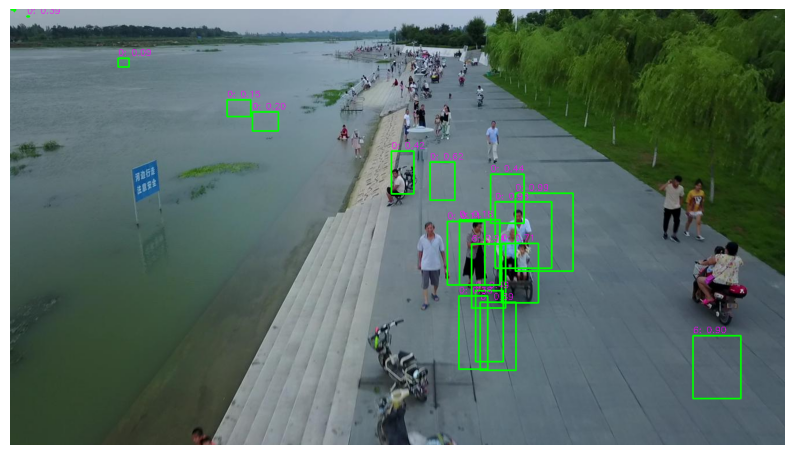

In [ ]:
## Visualizing predictions on images

def visualize_predictions(model, img_path, label_map, threshold=0.3, iou_threshold=0.5, top_k=20):
    # --- Load image ---
    orig_img = cv2.imread(img_path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    h, w, _ = orig_img.shape

    input_img = cv2.resize(orig_img, (224, 224)) / 255.0
    input_tensor = tf.expand_dims(input_img, axis=0)

    # --- Predict ---
    bbox_pred, objectness_pred, class_logits = model.predict(input_tensor)
    bbox_pred = bbox_pred[0]  # (196, 4)
    objectness_pred = objectness_pred[0]  # (196,)
    class_probs = tf.nn.softmax(class_logits[0], axis=-1)  # (196, num_classes)
    print("Sample objectness scores:", objectness_pred[:20])


    # --- Filter boxes with objectness > threshold ---
    mask = objectness_pred > threshold
    num_passed = tf.reduce_sum(tf.cast(mask, tf.int32)).numpy()
    print(f"[DEBUG] Objectness > {threshold}: {num_passed} boxes passed")

    if num_passed == 0:
        print("[DEBUG] No boxes passed threshold. Exiting visualization.")
        return

    boxes = bbox_pred[mask]
    scores = objectness_pred[mask]
    classes = tf.argmax(class_probs[mask], axis=-1).numpy()

    # --- Apply NMS ---
    selected_indices = tf.image.non_max_suppression(
        boxes=boxes,
        scores=scores,
        max_output_size=top_k,
        iou_threshold=iou_threshold
    ).numpy()

    print(f"[DEBUG] Boxes after NMS: {len(selected_indices)}")

    if len(selected_indices) == 0:
        print("[DEBUG] NMS removed all boxes.")
        return

    selected_boxes = tf.gather(boxes, selected_indices).numpy()
    selected_scores = tf.gather(scores, selected_indices).numpy()
    selected_classes = tf.gather(classes, selected_indices)

    # --- Rescale boxes to original image size ---
    h_scale = h / 224
    w_scale = w / 224

    for i in range(len(selected_boxes)):
        x1, y1, x2, y2 = selected_boxes[i]
        x1 = int(x1 * w_scale)
        y1 = int(y1 * h_scale)
        x2 = int(x2 * w_scale)
        y2 = int(y2 * h_scale)

        # Convert to native Python types
        label_id = int(selected_classes[i])
        label = label_map.get(label_id, str(label_id))
        score = float(selected_scores[i])

        # Draw box and label
        cv2.rectangle(orig_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(orig_img, f"{label}: {score:.2f}", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 255), 1)

    # --- Show image ---
    plt.figure(figsize=(10, 8))
    plt.imshow(orig_img)
    plt.axis('off')
    plt.show()



# Visualize prediction from your model on a training image
visualize_predictions(model, img_path=img_files[10], label_map=labels, threshold=0.01)


In [50]:
model.save("custom_model.keras")

In [32]:
import cv2
import os
import numpy as np
import tensorflow as tf
from simple_tracker import SimpleTracker
from tensorflow.nn import softmax
from glob import glob
import matplotlib.pyplot as plt

# --- Paths ---
FRAME_DIR = "../data/VisDrone2019/val/sequences/uav0000137_00458_v"
frame_paths = sorted(glob(os.path.join(FRAME_DIR, "*.jpg")))

# --- Load Model & Tracker ---
# model = tf.keras.models.load_model("your_trained_model_path")  # or use `model` if in memory
tracker = SimpleTracker(max_lost=5, iou_threshold=0.3)

label_map = {0: "background", 1: "pedestrian", 2: "car", 3: "truck", 4: "bus"}  # update to match your dataset
IMG_SIZE = (224, 224)

# --- Process Each Frame ---
for img_path in frame_paths:
    print(f"[INFO] Processing {img_path}")
    frame = cv2.imread(img_path)
    if frame is None:
        print(f"[WARNING] Couldn't load image: {img_path}")
        continue

    orig = frame.copy()
    h, w, _ = orig.shape

    # Preprocess
    input_img = cv2.resize(orig, IMG_SIZE) / 255.0
    input_tensor = tf.expand_dims(input_img, axis=0)

    # Inference
    bbox_pred, objectness_pred, class_logits = model.predict(input_tensor)
    objectness_pred = tf.sigmoid(objectness_pred[0])
    bbox_pred = bbox_pred[0]
    class_probs = tf.nn.softmax(class_logits[0], axis=-1)
    class_ids = tf.argmax(class_probs, axis=-1).numpy()
    scores = objectness_pred.numpy()

    # Filter and collect boxes
    threshold = 0.3
    boxes = []
    for i in range(len(scores)):
        if scores[i] > threshold:
            box = bbox_pred[i]
            box = [
                int(box[0] * w / IMG_SIZE[1]),
                int(box[1] * h / IMG_SIZE[0]),
                int(box[2] * w / IMG_SIZE[1]),
                int(box[3] * h / IMG_SIZE[0])
            ]
            boxes.append((box, int(class_ids[i])))

    print(f"[DEBUG] Detections: {len(boxes)}")

    # Tracker
    tracks = tracker.update(boxes)

    for track_id, data in tracks.items():
        x1, y1, x2, y2 = map(int, data["box"])
        cls = data["class"]
        label = label_map.get(cls, str(cls))
        text = f"ID:{track_id} {label}"
        cv2.rectangle(orig, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(orig, text, (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 255), 1)

    # Show
    cv2.imshow("Tracking", orig)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cv2.destroyAllWindows()


[INFO] Processing ../data/VisDrone2019/val/sequences/uav0000137_00458_v/0000001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[DEBUG] Detections: 196
[INFO] Processing ../data/VisDrone2019/val/sequences/uav0000137_00458_v/0000002.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[DEBUG] Detections: 196
[INFO] Processing ../data/VisDrone2019/val/sequences/uav0000137_00458_v/0000003.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
[DEBUG] Detections: 196
[INFO] Processing ../data/VisDrone2019/val/sequences/uav0000137_00458_v/0000004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[DEBUG] Detections: 196
[INFO] Processing ../data/VisDrone2019/val/sequences/uav0000137_00458_v/0000005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
[DEBUG] Detections: 196
[INFO] Processing ../data/VisDrone2019/val/sequences/uav0000137_00458_v/0000006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[DEBUG] Detections: 196
[INFO] Processing ../data/VisDrone2019/val/sequences/uav0000137_00458_v/0000007.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[D

### Trying pre-trained model (YOLOv8 + ByteTrack)